In [81]:
from io import StringIO
import os

import boto3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', 50)

In [40]:
aws_access_key_id = os.getenv('AWS_ACCESS_KEY')
aws_secretkey_id = os.getenv('AWS_SECRET_KEY')

In [41]:
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secretkey_id)
bucket = 'cubix-chicago-taxi-zsigy'

In [42]:
def read_csv_from_s3(bucket: str, path: str, filename:str) -> pd.DataFrame:
    """ Downloads a csv file from an s3 bucket.

    Args:
        bucket (str):
            The bucket where the file is.
        path (str):
            The folder of the file.
        filename (str):
            The name of the file.
        
    Returns:
        pd.DataFrame:
            The DataFrame of the downloaded file.
    """

    full_path = f'{path}{filename}'
    object = s3.get_object(Bucket=bucket, Key=full_path)
    object = object['Body'].read().decode('utf-8')
    # with StringIO the Body of the object behaves as a file
    df = pd.read_csv(StringIO(object))
    
    return df


In [43]:
community_areas_path = 'transformed_data/community_areas/'
company_path = 'transformed_data/company/'
date_path = 'transformed_data/date/'
payment_type_path = 'transformed_data/payment_types/'
taxi_trips_path = 'transformed_data/taxi_trips/'
weather_path = 'transformed_data/weather/'

In [44]:
community_areas = read_csv_from_s3(bucket= bucket, path= community_areas_path, filename= 'community_areas_master.csv')
print(community_areas.head())
company = read_csv_from_s3(bucket= bucket, path= company_path, filename='company_master.csv')
print(company.head())
date = read_csv_from_s3(bucket= bucket, path= date_path, filename= 'date_dimension.csv')
print(date.head())
payment_types = read_csv_from_s3(bucket= bucket, path= payment_type_path, filename= 'payment_type_master.csv')
print(payment_types.head())

   area_code  community_name
0          1     Rogers Park
1          2      West Ridge
2          3          Uptown
3          4  Lincoln Square
4          5    North Center
   company_id                       company
0           1                   5 Star Taxi
1           2     Taxi Affiliation Services
2           3                     Flash Cab
3           4                      Sun Taxi
4           5  Taxicab Insurance Agency Llc
         Date  year  month  day  day_of_week  is_week_end
0  2023-01-01  2023      1    1            7         True
1  2023-01-02  2023      1    2            1        False
2  2023-01-03  2023      1    3            2        False
3  2023-01-04  2023      1    4            3        False
4  2023-01-05  2023      1    5            4        False
   payment_type_id payment_type
0                1       Mobile
1                2         Cash
2                3  Credit Card
3                4       Prcard
4                5      Unknown


In [45]:
trips_list = []
weather_list = []

In [46]:
for file in s3.list_objects(Bucket = bucket, Prefix = taxi_trips_path)['Contents']:
    taxi_trip_file_key = file['Key']
    if taxi_trip_file_key.split('/')[-1].strip() != '':
        if taxi_trip_file_key.split('.')[1] == 'csv':
            filename = taxi_trip_file_key.split('/')[-1]
            trip = read_csv_from_s3(bucket= bucket, path= taxi_trips_path, filename= filename)
            trips_list.append(trip)
            print(f'{filename} has been added.')


taxi_2023-11-18.csv has been added.
taxi_2023-11-19.csv has been added.
taxi_2023-11-20.csv has been added.
taxi_2023-11-21.csv has been added.
taxi_2023-11-22.csv has been added.
taxi_2023-11-23.csv has been added.
taxi_2023-11-24.csv has been added.
taxi_2023-11-25.csv has been added.
taxi_2023-11-26.csv has been added.
taxi_2023-11-27.csv has been added.
taxi_2023-11-28.csv has been added.
taxi_2023-11-29.csv has been added.
taxi_2023-11-30.csv has been added.
taxi_2023-12-01.csv has been added.
taxi_2023-12-02.csv has been added.
taxi_2023-12-03.csv has been added.
taxi_2023-12-04.csv has been added.
taxi_2023-12-05.csv has been added.
taxi_2023-12-06.csv has been added.


In [47]:
trips = pd.concat(trips_list, ignore_index=True)

In [48]:
trips.shape

(278740, 20)

In [49]:
for file in s3.list_objects(Bucket = bucket, Prefix = weather_path)['Contents']:
    weather_file_key = file['Key']
    if weather_file_key.split('/')[-1].strip() != '':
        if weather_file_key.split('.')[1] == 'csv':       
            filename = weather_file_key.split('/')[-1]
            weather = read_csv_from_s3(bucket= bucket, path= weather_path, filename= filename)
            weather_list.append(weather)
            print(f'{filename} has been added.')            


weather_2023-11-18.csv has been added.
weather_2023-11-19.csv has been added.
weather_2023-11-20.csv has been added.
weather_2023-11-21.csv has been added.
weather_2023-11-22.csv has been added.
weather_2023-11-23.csv has been added.
weather_2023-11-24.csv has been added.
weather_2023-11-25.csv has been added.
weather_2023-11-26.csv has been added.
weather_2023-11-27.csv has been added.
weather_2023-11-28.csv has been added.
weather_2023-11-29.csv has been added.
weather_2023-11-30.csv has been added.
weather_2023-12-01.csv has been added.
weather_2023-12-02.csv has been added.
weather_2023-12-03.csv has been added.
weather_2023-12-04.csv has been added.
weather_2023-12-05.csv has been added.
weather_2023-12-06.csv has been added.


In [50]:
weather = pd.concat(weather_list, ignore_index=True)

In [51]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       456 non-null    object 
 1   temperature    456 non-null    float64
 2   wind_speed     456 non-null    float64
 3   rain           456 non-null    float64
 4   precipitation  456 non-null    float64
dtypes: float64(4), object(1)
memory usage: 17.9+ KB


#### Join the dataframes together

In [52]:
trips_full = pd.merge(trips, weather, left_on='datetime_for_weather', right_on='datetime', how='inner')
trips_full = trips_full.drop(columns=['datetime'])

In [53]:
trips_full = pd.merge(trips_full, company, left_on='company_id', right_on='company_id', how='inner')
trips_full = trips_full.drop(columns=['company_id'])

In [54]:
trips_full = pd.merge(trips_full, company, left_on='company_id', right_on='company_id', how='inner')
trips_full = trips_full.drop(columns=['company_id'])

KeyError: 'company_id'

In [58]:
trips_full = pd.merge(trips_full, payment_types, left_on='payment_type_id', right_on='payment_type_id', how='inner')
trips_full = trips_full.drop(columns=['payment_type_id'])

In [59]:
trips_full = pd.merge(trips_full, community_areas, left_on='pickup_community_area_id', right_on='area_code', how='inner')
trips_full = trips_full.drop(columns=['pickup_community_area_id', 'area_code'])
trips_full.rename(columns={'community_name':'pickup_community_area_name'}, inplace=True)

In [60]:
trips_full = pd.merge(trips_full, community_areas, left_on='dropoff_community_area_id', right_on='area_code', how='inner')
trips_full = trips_full.drop(columns=['dropoff_community_area_id', 'area_code'])
trips_full.rename(columns={'community_name':'dropoff_community_area_name'}, inplace=True)

In [67]:
date['date'] = pd.to_datetime(date['Date'])
date.drop(columns=['Date'], inplace=True)

In [ ]:
trips_full['trip_start_timestamp'] = pd.to_datetime(trips_full['trip_start_timestamp'])

In [72]:
trips_full['trip_start_date'] = trips_full['trip_start_timestamp'].dt.date

In [75]:
trips_full['trip_start_date'] = pd.to_datetime(trips_full['trip_start_date'])

In [76]:
trips_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278740 entries, 0 to 278739
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   trip_id                      278740 non-null  object        
 1   taxi_id                      278740 non-null  object        
 2   trip_start_timestamp         278740 non-null  datetime64[ns]
 3   trip_end_timestamp           278740 non-null  object        
 4   trip_seconds                 278740 non-null  int64         
 5   trip_miles                   278740 non-null  float64       
 6   fare                         278740 non-null  float64       
 7   tips                         278740 non-null  float64       
 8   tolls                        278740 non-null  float64       
 9   extras                       278740 non-null  float64       
 10  trip_total                   278740 non-null  float64       
 11  pickup_centroid_latitude  

In [77]:
trips_full = pd.merge(trips_full, date, left_on='trip_start_date', right_on='date', how='inner')

In [79]:
trips_full.drop(columns=['date'], inplace=True)

In [80]:
trips_full.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,temperature,wind_speed,rain,precipitation,company,payment_type,pickup_community_area_name,dropoff_community_area_name,trip_start_date,year,month,day,day_of_week,is_week_end
0,ad6bac72a079e03c8313cc17ace346a1e5c8bb09,314f48fcaf3556a8f1c5a32b497057bb479a7afded63d2...,2023-11-18 23:00:00,2023-11-19T00:00:00.000,372,1.95,10.00,2.79,0.0,0.0,12.79,41.922686,-87.649489,41.944227,-87.655998,2023-11-18 23:00:00,6.3,15.2,0.0,0.0,5 Star Taxi,Mobile,Lincoln Park,Lake View,2023-11-18,2023,11,18,6,True
1,58bcbf8f393a80724715f63a14a059c0ea375b34,c38a211cb84a44a24e959493d5842a48dd150b1e947b30...,2023-11-18 17:00:00,2023-11-18T17:15:00.000,548,1.33,9.00,2.00,0.0,0.0,11.00,41.922686,-87.649489,41.944227,-87.655998,2023-11-18 17:00:00,7.5,20.0,0.0,0.0,5 Star Taxi,Mobile,Lincoln Park,Lake View,2023-11-18,2023,11,18,6,True
2,fc5d310b903335f7fc74f23a4afa39bfb0628ec2,fb0ce19e30e712c77c57cfdb6ef729c2d2ad73225d9ec3...,2023-11-18 12:00:00,2023-11-18T12:30:00.000,293,0.00,9.00,1.67,0.0,0.0,10.67,41.922686,-87.649489,41.944227,-87.655998,2023-11-18 12:00:00,-1.3,10.0,0.0,0.0,5 Star Taxi,Mobile,Lincoln Park,Lake View,2023-11-18,2023,11,18,6,True
3,b392cc8e597e0bddaf30d83e01a03fcc65b8b361,137d4f780c3823fdc5f26cec160a8c9f8eb952f769c5bc...,2023-11-18 21:00:00,2023-11-18T22:00:00.000,419,0.00,9.00,1.67,0.0,0.0,10.67,41.922686,-87.649489,41.944227,-87.655998,2023-11-18 21:00:00,9.6,19.4,0.0,0.0,Flash Cab,Mobile,Lincoln Park,Lake View,2023-11-18,2023,11,18,6,True
4,32eadfa1696cb9444f1f0b50e2e138fa61fff65c,e93472aad9e00c0a523e1a861ae897303548d713ba63d3...,2023-11-18 21:00:00,2023-11-18T21:30:00.000,690,0.00,9.52,2.41,0.0,0.0,11.93,41.922686,-87.649489,41.944227,-87.655998,2023-11-18 21:00:00,9.6,19.4,0.0,0.0,Flash Cab,Mobile,Lincoln Park,Lake View,2023-11-18,2023,11,18,6,True


#### Visualizations

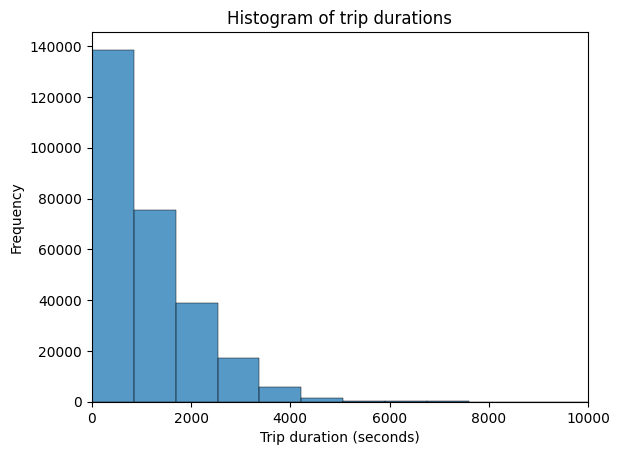

In [84]:
# 1 - Histogram of trip durations

sns.histplot(trips_full['trip_seconds'], bins=100, kde=False)
plt.title('Histogram of trip durations')
plt.xlabel('Trip duration (seconds)')
plt.ylabel('Frequency')
plt.xlim(0, 10000)
plt.show()

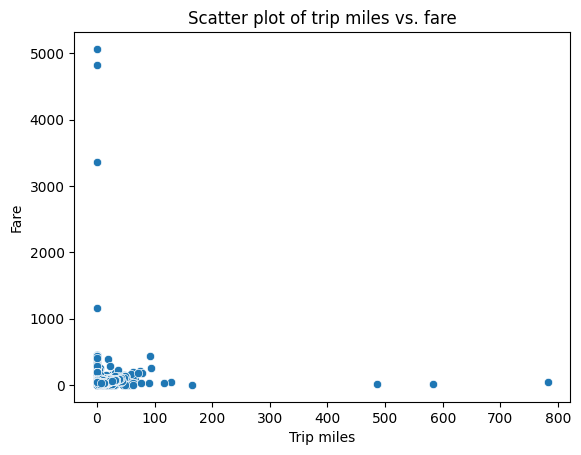

In [85]:
# 2 -Scatter plot of trip miles vs. fare

sns.scatterplot(x='trip_miles', y='fare', data=trips_full)
plt.title('Scatter plot of trip miles vs. fare')
plt.xlabel('Trip miles')
plt.ylabel('Fare')
plt.show()

C:\Users\zselyigy\AppData\Local\Temp\ipykernel_9004\3493730719.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y= 'fare', data=trips_full, ci=None)


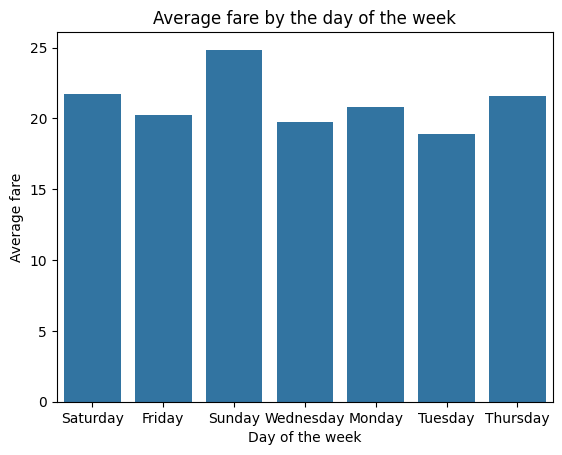

In [88]:
# 3 - Average fare by the day of the week

trips_full['day_of_week'] = trips_full['trip_start_timestamp'].dt.day_name()
sns.barplot(x='day_of_week', y= 'fare', data=trips_full, errorbar=None)
plt.title('Average fare by the day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Average fare')
plt.show()

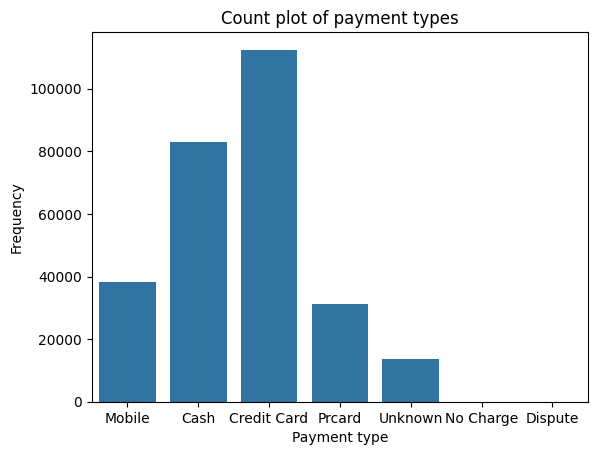

In [89]:
# 4 - Count plot of payment types

sns.countplot(x='payment_type', data=trips_full)
plt.title('Count plot of payment types')
plt.xlabel('Payment type')
plt.ylabel('Frequency')
plt.show()

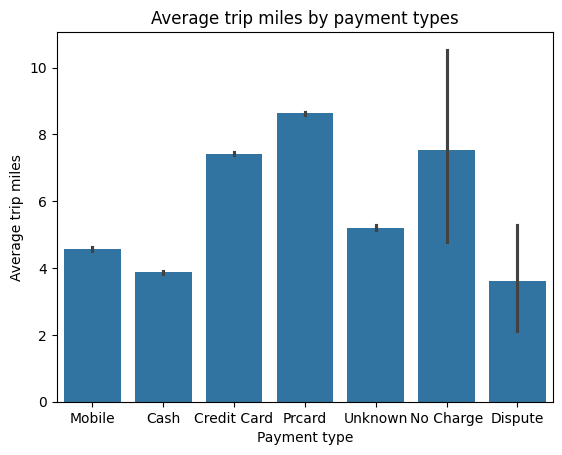

In [90]:
# 5 - Average trip miles by payment types

sns.barplot(x='payment_type', y= 'trip_miles', data=trips_full)
plt.title('Average trip miles by payment types')
plt.xlabel('Payment type')
plt.ylabel('Average trip miles')
plt.show()

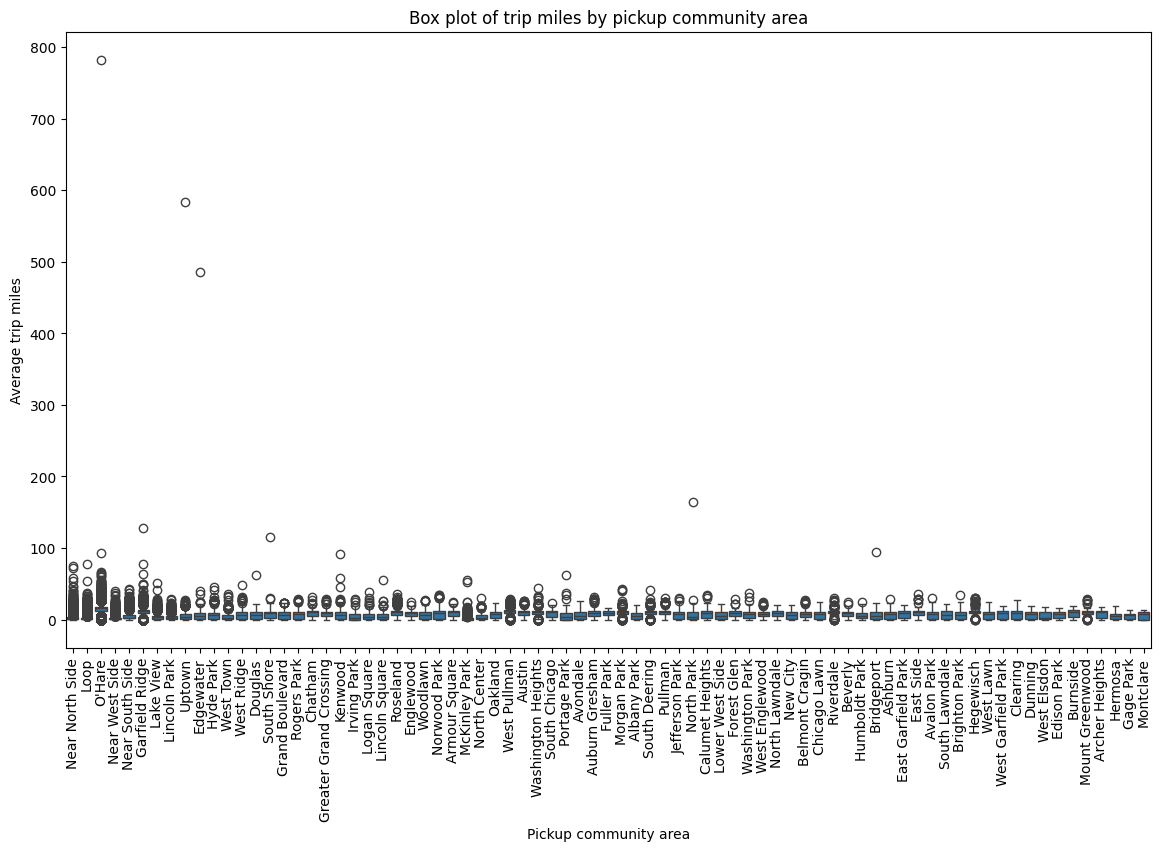

In [91]:
# 6 - Box plot of trip miles by pickup community area

plt.figure(figsize=(14, 8))
sns.boxplot(x='pickup_community_area_name', y= 'trip_miles', data=trips_full, order=trips_full['pickup_community_area_name'].value_counts().index)
plt.title('Box plot of trip miles by pickup community area')
plt.xlabel('Pickup community area')
plt.ylabel('Average trip miles')
plt.xticks(rotation=90)
plt.show()